In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Import the image to be processed

This image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


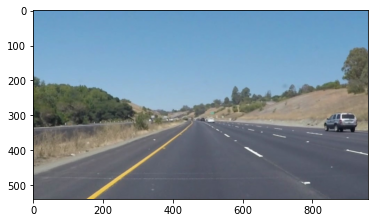

In [2]:
image = mpimg.imread('test_images/solidYellowCurve.jpg')
print('This image is: ',type(image), 'with dimensions: ', image.shape)
plt.imshow(image)

### Some Helper functions :
 * this block contains multiple funtions which have been created for ease of final pipeline for this project.

In [3]:
def color_selection(image):
    # converting given RGB image into HSV color model
    HSV_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # detecting white lines whose intensity varies from 200 to 255 for RGB colors.
    White = cv2.inRange(image, (200, 200, 200), (255, 255, 255))
    # plt.imshow(White)

    # detecting yellow lines using HSV converted image
    # the values for rue 17, saturation 70 were obtained from trial and error basis
    Yellow = cv2.inRange(HSV_image, (17, 70, 34), (30, 255, 255))
    # plt.imshow(Yellow)

    # once both white and yellow lanes are obtained, we will merge them using bitwise_or function from cv2 and set other color pixels to 0.
    mask_color = cv2.bitwise_or(White, Yellow)
    masked_image = np.copy(image)
    masked_image[mask_color == 0] = [0, 0, 0]
    # plt.imshow(masked_image)
    return masked_image

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def average_intercept_slope(lines):
    """
    This method help us to define left lane and right lane by calculating slope and intercept of lines.
    """
    left_line = []
    left_len = []
    right_line = []
    right_len = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue     # this will ignore a vertical line which will result in infinite slope
            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1
            length = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
            if m < 0:
                left_line.append((m, b))
                left_len.append(length)
            else:
                right_line.append((m, b))
                right_len.append(length)

    
    left_lane = np.dot(left_len, left_line) / np.sum(left_len) if len(left_len) > 0 else None
    right_lane = np.dot(right_len, right_line) / np.sum(right_len) if len(right_len) > 0 else None

    return left_lane, right_lane

def line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    m, b = line

    x1 = int((y1 - b) / m)
    x2 = int((y2 - b) / m)
    y1 = int(y1)
    y2 = int(y2)
    
    return [x1, y1, x2, y2]


def draw_lines(img, lines, color=[0, 0, 255], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lane, right_lane = average_intercept_slope(lines)

    y1 = img.shape[0]   # bottom of the image
    y2 = y1 * 0.6       # middle point of the image. this point is slightly lower than actual middle
    
    left_line = line_points(y1, y2, left_lane)
    right_line = line_points(y1, y2, right_lane)
    if left_line and right_line is not None:
        cv2.line(img, (left_line[0], left_line[1]), (left_line[2], left_line[3]), [255, 255, 0], thickness)
        cv2.line(img, (right_line[0], right_line[1]), (right_line[2], right_line[3]), [0, 255, 255], thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Steps of pipline :
* This below code blocks are defined individually to show what changes each section of the code makes to the code.

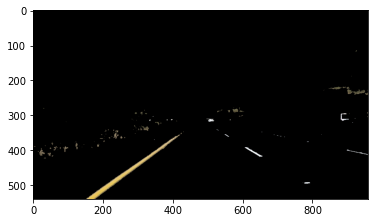

In [7]:
# converting given RGB image into HSV color model
HSV_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# detecting white lines whose intensity varies from 200 to 255 for RGB colors.
White = cv2.inRange(image, (200, 200, 200), (255, 255, 255))

# detecting yellow lines using HSV converted image
# the values for rue 17, saturation 70 were obtained from trial and error basis
Yellow = cv2.inRange(HSV_image, (17, 70, 34), (30, 255, 255))

# once both white and yellow lanes are obtained, we will merge them using bitwise_or function from cv2 and set other color pixels to 0.
mask_color = cv2.bitwise_or(White, Yellow)
masked_image = np.copy(image)
masked_image[mask_color == 0] = [0, 0, 0]
plt.imshow(masked_image)
plt.savefig('examples/color_selection.jpg')

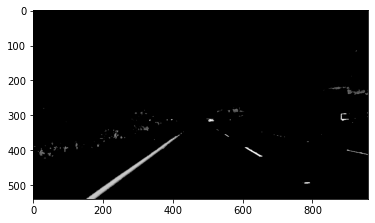

In [8]:
gray = grayscale(masked_image)
plt.imshow(gray, cmap='gray')
plt.savefig('examples/gray.jpg')

* gaussian blur image.

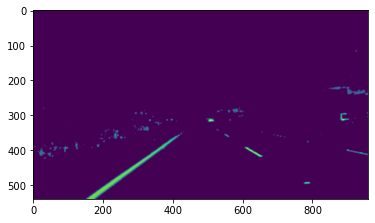

In [9]:
kernal_size = 5
blur_gray = gaussian_blur(gray, kernal_size)
plt.imshow(blur_gray)
plt.savefig('examples/blur_gray.jpg')

* use of canny edge detection to detect the lane line.

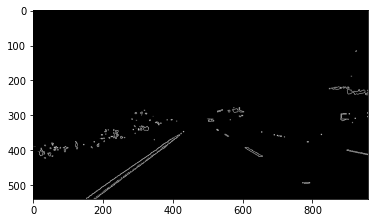

In [10]:
low_threshold = 200
high_threshold = 250
edges = canny(gray, low_threshold, high_threshold)
plt.imshow(edges, cmap = 'Greys_r')
plt.savefig('examples/canny_edges.jpg')

* selecting region of interest to neglact non useful data from image.

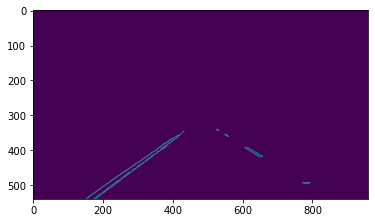

In [11]:
# Region of interest start
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    # This time we are defining a four sided polygon to mask
mask = np.zeros_like(edges)   
ignore_mask_color = 255 
imshape = image.shape
    # vertices = np.array([[(image.shape[0]-100,imshape[0]),(425, 300), (500, 300), (900,imshape[0])]], dtype=np.int32)
    
point_A = (imshape[1]*0.1, imshape[0])       # (50,imshape[0])
point_B = (imshape[1]*0.45, imshape[0]*0.6)   # (425, 300)
point_C = (imshape[1]*0.55, imshape[0]*0.6)   # (500, 300)
point_D = (imshape[1]*0.95, imshape[0])       # (900,imshape[0])

vertices = np.array([[point_A,point_B, point_C, point_D]], dtype=np.int32)
    
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges)
plt.savefig('examples/ROI.jpg')
    # End of region of intrest

* Drawing lines using houghs line method and then combining those details with the color image to display lane line of colored image.

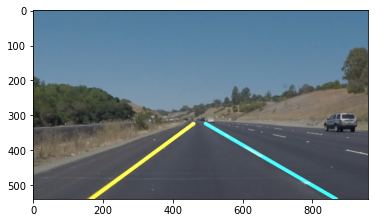

In [12]:
 # From this part Hough transform paramenters starts
rho = 1
theta = np.pi/180
threshold = 50
min_line_length = 100
max_line_gap = 160
line_image = np.copy(image)*0 # For creating a blank to draw lines on
    
    # masked edges is the output image of region of intrest
    
lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    #color_edges = np.dstack((masked_edges, masked_edges, masked_edges))

combo = weighted_img(lines, image, 0.8, 1, 0)

plt.imshow(combo)
plt.savefig('examples/lane_lines.jpg')

### Pipline :
* Following code has process been piplined to be used in video processing.

In [56]:
def process_image(image):
    # TODO: put your pipeline here, you should return the final output (image where lines are drawn on lanes)
    
    mask_image = color_selection(image)
    # gray contains the gray scale version of image
    gray = grayscale(mask_image)
    #plt.imshow(gray)

    kernal_size = 5
    blur_gray = gaussian_blur(gray, kernal_size)
    plt.imshow(blur_gray)

    # Now this gray image is further processed to filter out 
    # between low and high threshold and detect edges with 
    # canny edge detection method
    low_threshold = 200
    high_threshold = 250
    edges = canny(gray, low_threshold, high_threshold)
    plt.imshow(edges, cmap = 'Greys_r')
    
    # Region of interest start
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    # This time we are defining a four sided polygon to mask
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255 
    imshape = image.shape
    # vertices = np.array([[(image.shape[0]-100,imshape[0]),(425, 300), (500, 300), (900,imshape[0])]], dtype=np.int32)
    
    point_A = (imshape[1]*0.1, imshape[0])       # (50,imshape[0])
    point_B = (imshape[1]*0.45, imshape[0]*0.6)   # (425, 300)
    point_C = (imshape[1]*0.55, imshape[0]*0.6)   # (500, 300)
    point_D = (imshape[1]*0.95, imshape[0])       # (900,imshape[0])

    vertices = np.array([[point_A,point_B, point_C, point_D]], dtype=np.int32)
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    # End of region of intrest

     # From this part Hough transform paramenters starts
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 20
    max_line_gap = 300
    line_image = np.copy(image)*0 # For creating a blank to draw lines on
    
    # masked edges is the output image of region of intrest
    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    #color_edges = np.dstack((masked_edges, masked_edges, masked_edges))

    combo = weighted_img(lines, image, 0.8, 1, 0)

    plt.imshow(combo)
    result = combo
    return result

### Video to be processed :
* Initially white image output is created where the processed frames from the video can be saved.


                                                         
t:   2%|▏         | 5/221 [11:48<00:09, 23.91it/s, now=None]
                                                         
t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]ow=None]

Moviepy - Building video test_videos_output/solidWhiteRight_blue.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight_blue.mp4



                                                              
                                                         
t:   2%|▏         | 5/221 [12:11<00:09, 23.91it/s, now=None]
                                                         
t:   2%|▏         | 5/221 [12:11<00:09, 23.91it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight_blue.mp4
CPU times: user 1min 41s, sys: 6.92 s, total: 1min 48s
Wall time: 23 s


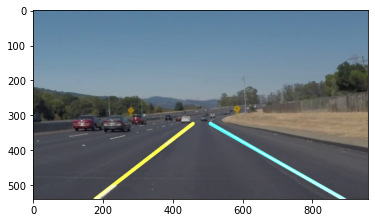

In [57]:
white_output = 'test_videos_output/solidWhiteRight_blue.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")    #.subclip(0,10)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


                                                         
t:   2%|▏         | 5/221 [10:06:29<00:09, 23.91it/s, now=None]
                                                            
t:   0%|          | 0/251 [00:00<?, ?it/s, now=None], now=None]

Moviepy - Building video test_videos_output/challenge_final_1.mp4.
Moviepy - Writing video test_videos_output/challenge_final_1.mp4



                                                              
                                                            
t:   2%|▏         | 5/221 [10:07:11<00:09, 23.91it/s, now=None]
                                                            
t:   2%|▏         | 5/221 [10:07:11<00:09, 23.91it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_final_1.mp4
CPU times: user 3min 13s, sys: 13.6 s, total: 3min 27s
Wall time: 41.8 s


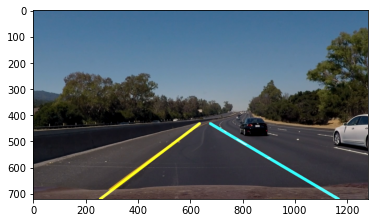

In [59]:
challenge_output = 'test_videos_output/challenge_final_1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [60]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))